In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# transformations
transform = T.Compose([T.ToTensor(),
                       T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root = './data', download = True, split = 'train', transform = transform)
testset = torchvision.datasets.STL10(root = './data', download = True, split = 'test', transform = transform)

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(testset, batch_size = 256)

100%|██████████| 2640397119/2640397119 [01:44<00:00, 25186245.51it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [6]:
# check out the shapes of the datasets
print('Data Shapes (train/test)')
print(trainset.data.shape)
print(testset.data.shape)

# and the range of pixel intensity values
print('\nData Value Range:')
print((np.min(trainset.data), np.max(trainset.data)))

# categories
print('\n Data Categories')
print(trainset.classes)

Data Shapes (train/test)
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data Value Range:
(0, 255)

 Data Categories
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [7]:
X, y = next(iter(train_loader))

print('Data shapes')
print(X.data.shape)

# and now the pixel intensity values
print('\nData Value range:')
print((torch.min(X.data), torch.max(X.data)))


Data shapes
torch.Size([32, 3, 96, 96])

Data Value range:
(tensor(-2.1179), tensor(2.6400))


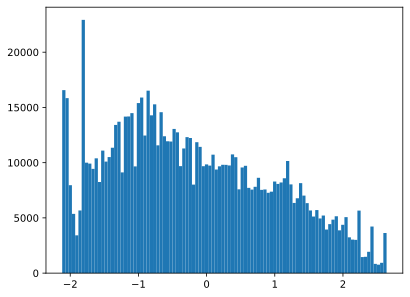

In [9]:
plt.hist(X.data.numpy().flatten(), 100)
plt.show()

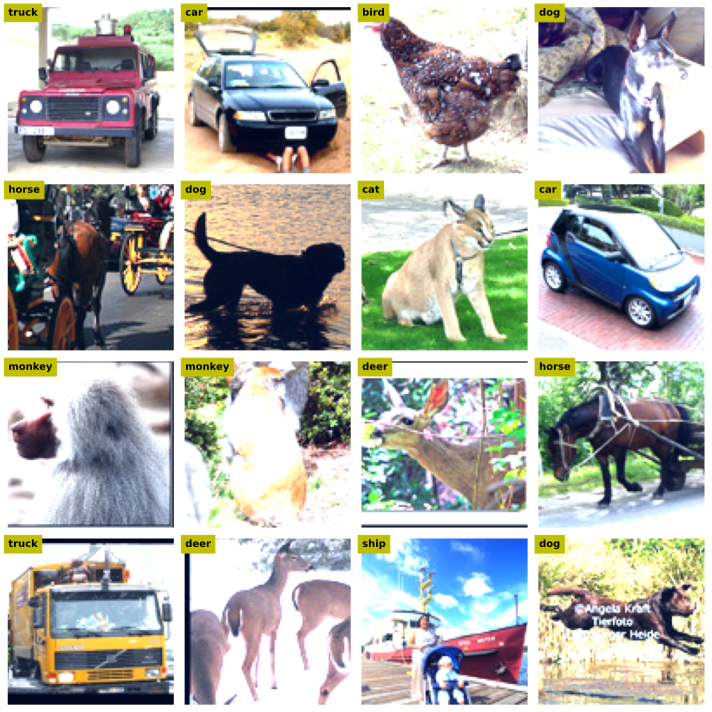

In [10]:
fig, axs = plt.subplots(4, 4, figsize = (10, 10))
for (i, ax) in enumerate(axs.flatten()):

    # extract that image
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = (pic-np.min(pic))/np.max(pic)

    # and its label
    label = trainset.classes[y[i]]

    # show
    ax.imshow(pic)
    ax.text(0, 0, label, ha = 'left', va = 'top', fontweight = 'bold', color = 'k', backgroundcolor = 'y')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
resnet = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.5MB/s]


In [13]:
resnet

<bound method ResNet.forward of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [14]:
from torchsummary import summary
summary(resnet.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [36]:
for p in resnet.parameters():
    p.requires_grad = False

In [38]:
resnet.fc = nn.Linear(512, 10)

In [17]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr = .001, momentum = .9)

In [30]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)


for epochi in range(numepochs):

    resnet.train()
    batchLoss = []
    batchAcc = []

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        yHat = resnet(X)
        loss = lossfun(yHat, y)
        yHat = yHat.cpu()
        y = y.cpu()
        batchLoss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        matches = ((torch.argmax(yHat, axis = 1) == y).float())
        accPct = 100*torch.mean(matches).item()
        batchAcc.append(accPct)

    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = np.mean(batchAcc)

    resnet.eval()
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        with torch.inference_mode():
            yHat = resnet(X)
            loss = lossfun(yHat, y)
            yHat = yHat.cpu()
            y = y.cpu()
            testLoss[epochi] = (loss.item())
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accPct = 100*torch.mean(matches).item()
            testAcc[epochi] = (accPct)

    print(f'Finished Epoch {epochi+1}/{numepochs}. Test Accuracy = {testAcc[epochi]:.2f}%')


Finished Epoch 1/10. Test Accuracu = 75.00%
Finished Epoch 2/10. Test Accuracu = 78.12%
Finished Epoch 3/10. Test Accuracu = 76.56%
Finished Epoch 4/10. Test Accuracu = 73.44%
Finished Epoch 5/10. Test Accuracu = 82.81%
Finished Epoch 6/10. Test Accuracu = 76.56%
Finished Epoch 7/10. Test Accuracu = 73.44%
Finished Epoch 8/10. Test Accuracu = 76.56%
Finished Epoch 9/10. Test Accuracu = 75.00%
Finished Epoch 10/10. Test Accuracu = 75.00%


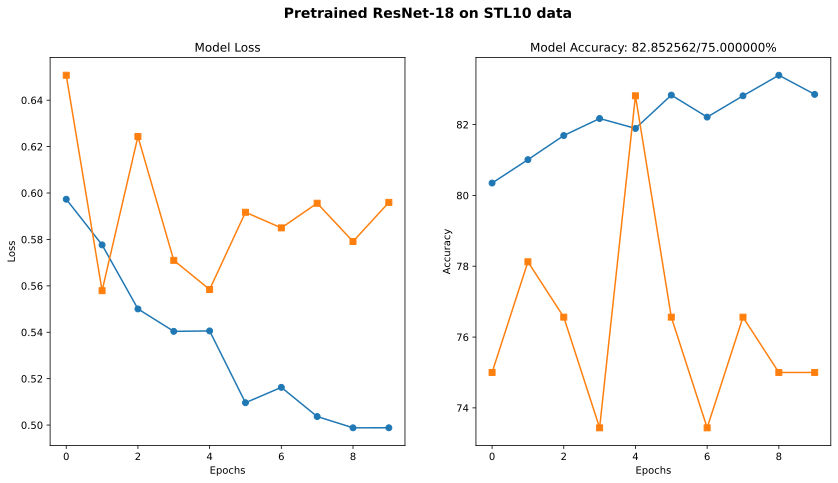

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))

ax[0].plot(trainLoss, 'o-',label = 'Train')
ax[0].plot(testLoss, 's-',label = 'Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, 'o-',label = 'Train')
ax[1].plot(testAcc, 's-',label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Model Accuracy: {trainAcc[-1]:2f}/{testAcc[-1]:2f}%')


plt.suptitle('Pretrained ResNet-18 on STL10 data', fontweight = 'bold', fontsize = 14)
plt.show()

device(type='cuda', index=0)

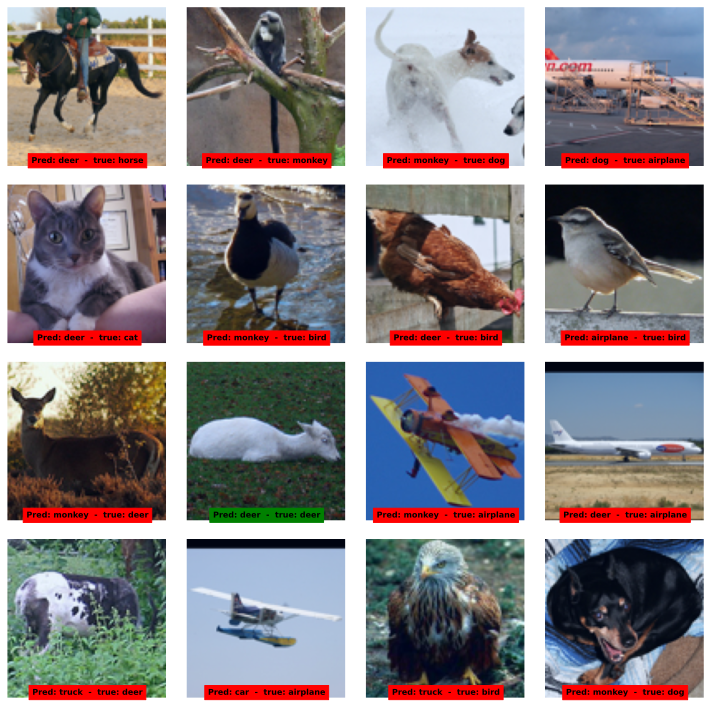

In [51]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.to(device)
resnet.eval()
predictions = resnet(X)
predictions = torch.argmax(predictions, axis = 1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()